# Multiple Important Sampling with Multi-Sample Model

The multi-sample model takes $ n_i > 0$ samples from each sampling strategy. The estimator is defined as:

Multi-sample model: $ \hat F= \sum_{i=1}^n {1 \over n_i} \sum_{j=1}^{n_i} { w_i(x) f(x) \over p_i(x) } $

where:
- $n$ - number of sampling strategies.
- $n_i$ - number of samples taken from the $ i $ th strategy (assuming $n_i > 0$).
- $w_i$ - weight function for the $ i $ th strategy.


Two conditions must hold for $ \hat F $ to be unbiased:
1. $w1: \sum_{i=1}^n w_i(x) = 1 $ when $ f(x) \ne 0 $ - The weights must sum to $ 1 $ where the integrand is non-zero.
2. $w2:$ If $ p_i(x) = 0 $ then $ w_i(x) = 0 $

From [Eric Veach's thesis](https://graphics.stanford.edu/courses/cs348b-03/papers/veach-chapter9.pdf), two notable choices for weight function:
1. The balance heuristic
    - $ \hat w_i(x) = {n_i p_i(x) \over \sum_k n_k p_k} $
2. The power heuristic - Parameter $ \beta \ge 1 $ suppresses smaller weights before normalization.
    - $ w_i(x) = { (n_i p_i)^{\beta} \over \sum_k (n_k p_k)^{\beta}} $

Combining the multi-sample model with balance heuristic gives: $ \sum_n \sum_{n_i} { f(x) \over \sum_k n_k p_k(x) } $

Alternatively, we can rearrange it to a more standard form: $ {1 \over N} \sum_n \sum_{n_i} { f(x) \over \sum_k c_k p_k(x) } $ where $ c_k $ is $ {n_i \over N} $ with $ N $ as the total number of samples.

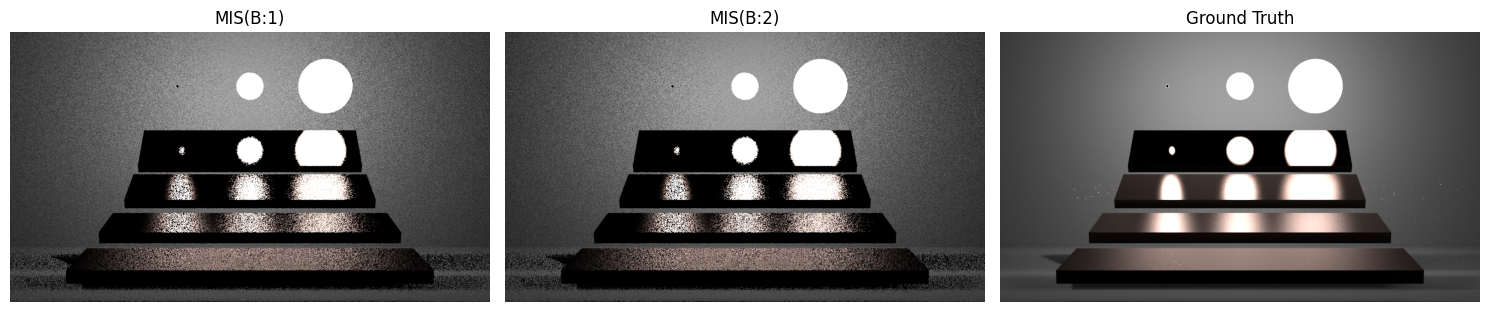

In [1]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
mi.set_variant('llvm_ad_rgb')

class MISIntegrator(mi.SamplingIntegrator):
    def __init__(self, props):
        super().__init__(props)
        self.B = props.get('B', 1) # Power heuristic constant, by default set to 1 which is equivalent to the balance heuristic

    def sample(self, scene, sampler, ray, medium, active):

        si = scene.ray_intersect(ray, active)
        result = mi.Spectrum(0.0)
        active &= si.is_valid()

        # Add contribution from directly hitting an emitter
        emitter_value = si.emitter(scene, active).eval(si, active)
        result[active] += emitter_value
        active = dr.select(dr.sum(emitter_value) > 0, False, active)
        
        # Number of samples for each sampling strategy
        n_light = 1
        n_bsdf = 1

        B = dr.ones(mi.Float, active.shape) * self.B

        if dr.any(active):

            # Sample using the BSDF sampling
            bsdf_mask = active
            bsdf_sample, bsdf_value = si.bsdf().sample(mi.BSDFContext(), si, sampler.next_1d(), sampler.next_2d(), bsdf_mask)
            bsdf_value *= bsdf_sample.pdf
            bsdf_mask &= bsdf_sample.pdf > 0

            light_ray = si.spawn_ray(si.to_world(bsdf_sample.wo))
            li = scene.ray_intersect(light_ray, bsdf_mask)

            emitter_value = li.emitter(scene, bsdf_mask).eval(li, bsdf_mask)

            ds = mi.DirectionSample3f(scene, li, si)
            light_pdf = scene.pdf_emitter_direction(si, ds, bsdf_mask)

            w = dr.power(n_bsdf * bsdf_sample.pdf, B - 1) / ( dr.power(n_bsdf * bsdf_sample.pdf, B) + dr.power(n_light * light_pdf, B) )
            result[bsdf_mask] += w * bsdf_value * emitter_value
        
            # Sample using the direct light sampling
            light_mask = active
            emitter_sample, emitter_value = scene.sample_emitter_direction(si, sampler.next_2d(), True, light_mask)
            emitter_value *= emitter_sample.pdf
            light_mask &= emitter_sample.pdf > 0

            bsdf_value, bsdf_pdf = si.bsdf().eval_pdf(mi.BSDFContext(), si, si.to_local(emitter_sample.d), light_mask)

            w = dr.power(n_light * emitter_sample.pdf, B - 1) / ( dr.power(n_bsdf * bsdf_pdf, B) + dr.power(n_light * emitter_sample.pdf, B) )
            result[light_mask] += w * emitter_value * bsdf_value


        return (result, active, [])

mi.register_integrator("mis", lambda props: MISIntegrator(props))

scene = mi.load_file("scenes/veach-mis/scene.xml")
mis_integrator_bh = mi.load_dict({ 'type': 'mis', 'B' : 1 })
mis_integrator_ph = mi.load_dict({ 'type': 'mis', 'B' : 2 })

mis_image_bh = mi.render(scene, integrator=mis_integrator_bh, spp=1)
mis_image_ph = mi.render(scene, integrator=mis_integrator_ph, spp=1)
gt_image = mi.render(scene, spp=128)

images = [mis_image_bh, mis_image_ph, gt_image]
titles = ['MIS(B:1)', 'MIS(B:2)', 'Ground Truth']

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(mi.util.convert_to_bitmap(img))
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()